# Q2: Cycle Generative Adversarial Network (CycleGAN)

In [1]:
# Load the necessary imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from library import datasets, models
from library.visualizations.point_pairs import visualize_point_correspondence
from library.utils.numerical_checking import NumericalCheckingRecord
from library.utils.helper_functions import check_model_forward, plot_generated_samples, plot_samples, plot_reconstructed_samples
from flax import linen as nn, serialization
from jax import random, numpy as jnp
import optax
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
pio.renderers.default = 'notebook_connected'

## Dataset

In the previous notebook, you saw how GAN tries to learn to generate samples from a desired distribution. In this notebook, you will use CycleGAN to learn how to map samples from one distribution to another. One of the key advantages of CycleGAN is that it does not require a paired dataset. Instead, it learns the sample-to-sample correspondence between two datasets by enforcing cycle consistency. In this homework, you will consider the mapping between two distributions of the blob dataset you saw in the GAN notebook. These are illustrated below.

In [2]:
key = random.PRNGKey(5)
key_A, key_B = random.split(key)

# Create dataset
A = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_A)
B = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_B)

real_A = A.get_tensors()
real_B = B.get_tensors()

In [3]:
plot_samples(real_A, real_B)

## Part (A): Initialize CycleGAN and interpret generated fake samples

Since you already learned how to create the discriminator and generator in the GAN notebook, you can reuse their architectures below. Remember that we have two different distributions now instead of one for GAN.

In [4]:
# Define ambient dimension, discriminator and generator
AMBIENT_DIM = 2

discriminator_A = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1),
])

discriminator_B = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1),
])

generator_AB = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM),
])

generator_BA = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM),
])


In [5]:
# Initialize model with generators, discriminators and loss function.
modules = {
        'generator_AB': generator_AB,
        'generator_BA': generator_BA,
        'discriminator_A': discriminator_A,
        'discriminator_B': discriminator_B,
    }

model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [6]:
# Get generators from untrained model and draw samples
model.load_states('checks/untrained_cycle_gan_states')
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

In [7]:
## Implementation check
expected_fake_A = NumericalCheckingRecord.load('checks/cyclegan_generatorBA_check')
expected_fake_B = NumericalCheckingRecord.load('checks/cyclegan_generatorAB_check')
assert expected_fake_A.data.shape == fake_A.shape, "Ensure output shape matches expected"
assert expected_fake_B.data.shape == fake_B.shape, "Ensure output shape matches expected"
assert expected_fake_A.check(fake_A), "Output does not match expected"
assert expected_fake_B.check(fake_B), "Output does not match expected"

In [8]:
plot_generated_samples(real_A, real_B, fake_A, fake_B)

**Q. Are the generated fake samples as you expected? Why or why not?**

Write your answers in the written portion.

## Part (B): Implement cycle consistency loss and train CycleGAN

For the CycleGAN model, we aim to solve the minimax game between the generators and the discriminators:
$$\underset{G_{AB}, G_{BA}}{min}\: \underset{D_A, D_B}{max}\: V(G_{AB}, G_{BA}, D_A, D_B) = \mathcal{L}(G_{AB},G_{BA},D_A, D_B)$$

The full objective is defined as:
$$\mathcal{L}(G_{AB},G_{BA},D_A, D_B) = \mathcal{L}(G_{AB},D_B,A,B) + \mathcal{L}(G_{BA},D_A,B,A) +\lambda \mathcal{L}_{cyc}(G_{AB}, G_{BA})$$
where $\lambda$ controls the relative importance of the two objectives (i.e. GAN or cycle consistency loss) and where the GAN and cycle consistency losses are defined as:
\begin{align*}
\mathcal{L}_{GAN}(G_{AB}, D_B, A, B) &= \mathbb{E}_{b \sim p_{data}(b)}\left[log \: D_B(b)\right]+\mathbb{E}_{a \sim p_{data}(a)}\left[log(1-D_B(G_{AB}(a)))\right] \\
\mathcal{L}_{cyc}(G_{AB}, G_{BA}) &= \mathbb{E}_{a \sim p_{data}(a)}\left[||G_{BA}(G_{AB}(a))-a||_1\right] + \mathbb{E}_{b \sim p_{data}(b)}\left[||G_{AB}(G_{BA}(b))-b||_1\right]
\end{align*}
Note that $\mathcal{L}(G_{BA},D_A,B,A)$ is calculated in similar fashion as $\mathcal{L}(G_{AB},D_B,A,B)$.


In this part, you should implement the GAN and cycle consistency loss functions from above in the train method in `cyclegan.py`. Once you have successfully implemented the functions, you can train the CycleGAN model below.

In [9]:
model.compile_generator_grad_fn(cycle_loss_weight=1.0, cycle_loss_mask='None')

model.load_states('checks/untrained_cycle_gan_states')

In [10]:
# TODO: These are code to generate checkpoints. REMOVE them in the homework notebook.

# from flax import serialization

# dummy_inputs_A = random.normal(random.PRNGKey(0), (100, AMBIENT_DIM))
# dummy_inputs_B = random.normal(random.PRNGKey(1), (100, AMBIENT_DIM))
    
# NumericalCheckingRecord((dummy_inputs_A, dummy_inputs_B)).save('checks/dummy_inputs_cyclegan.rec')
# NumericalCheckingRecord(model.eval_generator_grads(dummy_inputs_A, dummy_inputs_B)).save('checks/untrained_cyclegan_generator_gradients.rec')

In [11]:
dummy_inputs_A, dummy_inputs_B = NumericalCheckingRecord.load('checks/dummy_inputs_cyclegan.rec').data
gradients = model.eval_generator_grads(dummy_inputs_A, dummy_inputs_B)

record = NumericalCheckingRecord.load('checks/untrained_cyclegan_generator_gradients.rec')

assert record.check(gradients), 'Gradient checking failed!'

## Part (C): Training CycleGAN

In [12]:
# Train CycleGAN
lambda_ = 5
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=1000, cycle_loss_weight=lambda_)

Epoch 0; Generator AB GAN loss:  0.6995; Generator BA GAN loss:  0.7239; B->A->B cycle loss:  0.8255; A->B->A cycle loss:  0.7572; Discriminator A loss:  0.6781; Discriminator B loss:  0.7197: : 1it [00:03,  3.02s/it]
Epoch 1; Generator AB GAN loss:  0.6938; Generator BA GAN loss:  0.7383; B->A->B cycle loss:  0.8226; A->B->A cycle loss:  0.7075; Discriminator A loss:  0.6693; Discriminator B loss:  0.7117: : 1it [00:00,  6.14it/s]
Epoch 2; Generator AB GAN loss:  0.6899; Generator BA GAN loss:  0.7550; B->A->B cycle loss:  0.8195; A->B->A cycle loss:  0.6524; Discriminator A loss:  0.6586; Discriminator B loss:  0.7079: : 1it [00:00,  6.33it/s]
Epoch 3; Generator AB GAN loss:  0.6879; Generator BA GAN loss:  0.7762; B->A->B cycle loss:  0.8189; A->B->A cycle loss:  0.5913; Discriminator A loss:  0.6465; Discriminator B loss:  0.7041: : 1it [00:00,  6.58it/s]
Epoch 4; Generator AB GAN loss:  0.6867; Generator BA GAN loss:  0.8022; B->A->B cycle loss:  0.8153; A->B->A cycle loss:  0.523

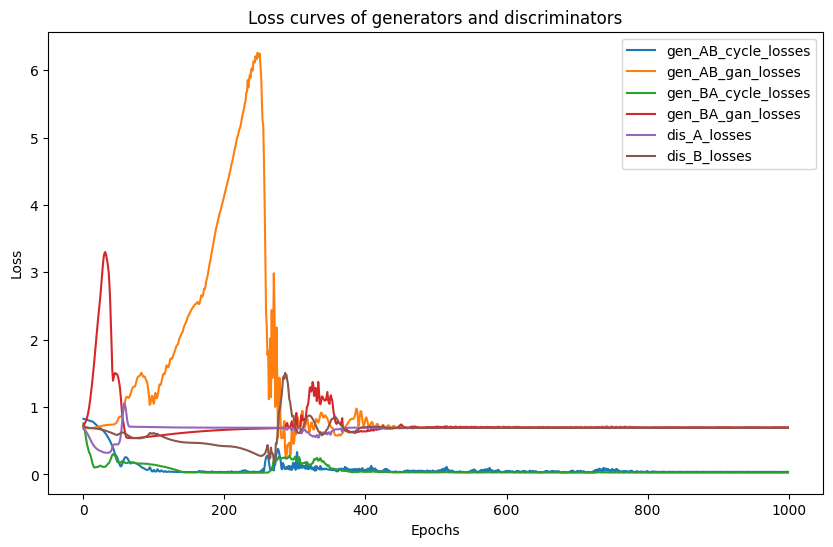

In [13]:
fig = plt.figure(figsize=(10, 6))
for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)
plt.legend()
plt.title("Loss curves of generators and discriminators")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

**Q. Looking at the loss curves above, can you identify a limitation of CycleGAN?**

Write your answers in the written portion.

Now, let's visualize how the generators transformed samples across distributions.

In [14]:
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.generator(real_B)
fake_B = gan_AB.generator(real_A)

In [15]:
plot_generated_samples(real_A, real_B, fake_A, fake_B)

## Part (D): Visualize sample correspondence

Explanation of the graphs:

The function `visualize_point_correspondence` visualizes the correspondence across two sets of points by giving points that correspond to each other the same color. The left subplot corresponds to the points passed in as the first argument, while the right subplot corresponds to the second argument. For example, if you call `visualize_point_correspondence(real_A, fake_B)`, where `fake_B` is transformed from `real_A` by the generator, then an orange point in the left subplot is transformed by the generator to the corresponding orange point in the right subplot.

In [16]:
visualize_point_correspondence(A.get_tensors(), fake_B, 'Real A', 'Fake B')

In [17]:
visualize_point_correspondence(B.get_tensors(), fake_A, 'Real B', 'Fake A')

In [18]:
visualize_point_correspondence(real_A, fake_A, "Real A", "Fake A")

In [19]:
visualize_point_correspondence(real_B, fake_B, "Real B", "Fake B")

**Q. Why does it seem that the clusters of real A samples and the clusters of fake A samples are switched, despite a low cycle loss observed at the end of training?**

Answer the question in written portion.

In [20]:
# TODO: the remaining cells in this question are SOLUTION ONLY. Remove them in the homework.
recon_A = gan_BA.generator(gan_AB.generator(real_A))
recon_B = gan_AB.generator(gan_BA.generator(real_B))

In [21]:
visualize_point_correspondence(real_A, recon_A, "Real A", "Reconstructed A")

In [22]:
visualize_point_correspondence(real_B, recon_B, "Real B", "Reconstructed B")

In [23]:
visualize_point_correspondence(real_A, real_B, "Real A", "Real B")

## Part (F): Pretraining with GAN loss only

**Before doing this part, you should conduct an ablation study by following the instructions in the [Ablation study notebook](homework_CycleGAN_Ablation.ipynb).** Please do so if you have not already.

For this part, run pretraining with only GAN loss and then introduce it after 500 epochs. You do not need to implement any code for Part (E) and (F).

### Pretrain with $\lambda = 0$

In [24]:
# Reinitialize
model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [25]:
# Pretrain
lambda_pretrain = 0
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_pretrain)

Epoch 0; Generator AB GAN loss:  0.6995; Generator BA GAN loss:  0.7239; B->A->B cycle loss:  0.8255; A->B->A cycle loss:  0.7572; Discriminator A loss:  0.6781; Discriminator B loss:  0.7197: : 1it [00:01,  1.77s/it]
Epoch 1; Generator AB GAN loss:  0.6922; Generator BA GAN loss:  0.7237; B->A->B cycle loss:  0.8235; A->B->A cycle loss:  0.7947; Discriminator A loss:  0.6768; Discriminator B loss:  0.7120: : 1it [00:00,  5.03it/s]
Epoch 2; Generator AB GAN loss:  0.6895; Generator BA GAN loss:  0.7218; B->A->B cycle loss:  0.8221; A->B->A cycle loss:  0.8270; Discriminator A loss:  0.6757; Discriminator B loss:  0.7078: : 1it [00:00,  5.69it/s]
Epoch 3; Generator AB GAN loss:  0.6881; Generator BA GAN loss:  0.7195; B->A->B cycle loss:  0.8247; A->B->A cycle loss:  0.8538; Discriminator A loss:  0.6748; Discriminator B loss:  0.7039: : 1it [00:00,  5.74it/s]
Epoch 4; Generator AB GAN loss:  0.6868; Generator BA GAN loss:  0.7165; B->A->B cycle loss:  0.8255; A->B->A cycle loss:  0.876

In [26]:
# Obtain generators and samples
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

# Visualize samples
plot_generated_samples(real_A, real_B, fake_A, fake_B)

### Now, train with both GAN loss and cycle loss.

In [27]:
# Further training
lambda_train = 5
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_train)

Epoch 0; Generator AB GAN loss:  1.3118; Generator BA GAN loss:  0.8324; B->A->B cycle loss:  1.0035; A->B->A cycle loss:  0.2829; Discriminator A loss:  0.5000; Discriminator B loss:  0.4291: : 1it [00:01,  1.07s/it]
Epoch 1; Generator AB GAN loss:  1.3511; Generator BA GAN loss:  1.1616; B->A->B cycle loss:  0.9989; A->B->A cycle loss:  0.2764; Discriminator A loss:  0.5245; Discriminator B loss:  0.4261: : 1it [00:00,  5.07it/s]
Epoch 2; Generator AB GAN loss:  1.3658; Generator BA GAN loss:  1.0556; B->A->B cycle loss:  0.9943; A->B->A cycle loss:  0.2708; Discriminator A loss:  0.5019; Discriminator B loss:  0.4249: : 1it [00:00,  5.35it/s]
Epoch 3; Generator AB GAN loss:  1.3375; Generator BA GAN loss:  1.2299; B->A->B cycle loss:  0.9936; A->B->A cycle loss:  0.2661; Discriminator A loss:  0.5010; Discriminator B loss:  0.4244: : 1it [00:00,  5.66it/s]
Epoch 4; Generator AB GAN loss:  1.3732; Generator BA GAN loss:  1.1433; B->A->B cycle loss:  0.9926; A->B->A cycle loss:  0.262

In [28]:
# Obtain generators and samples
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

# Visualize samples
plot_generated_samples(real_A, real_B, fake_A, fake_B)

**Q. How does pretraining without cycle loss affect subsequent training where cycle loss is present? Can you give a possible explanation?**

Write your answers in the written portion.

## Part (G): Pretraining with GAN loss and cycle consistency loss

In [29]:
# Reinitialize
model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

### Pretrain with $\lambda = 5$

In [30]:
# Pretrain
lambda_pretrain = 5
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=1000, cycle_loss_weight=lambda_pretrain)

Epoch 0; Generator AB GAN loss:  0.6995; Generator BA GAN loss:  0.7239; B->A->B cycle loss:  0.8255; A->B->A cycle loss:  0.7572; Discriminator A loss:  0.6781; Discriminator B loss:  0.7197: : 1it [00:01,  1.31s/it]
Epoch 1; Generator AB GAN loss:  0.6938; Generator BA GAN loss:  0.7383; B->A->B cycle loss:  0.8226; A->B->A cycle loss:  0.7075; Discriminator A loss:  0.6693; Discriminator B loss:  0.7117: : 1it [00:00,  7.13it/s]
Epoch 2; Generator AB GAN loss:  0.6899; Generator BA GAN loss:  0.7550; B->A->B cycle loss:  0.8195; A->B->A cycle loss:  0.6524; Discriminator A loss:  0.6586; Discriminator B loss:  0.7079: : 1it [00:00,  7.12it/s]
Epoch 3; Generator AB GAN loss:  0.6879; Generator BA GAN loss:  0.7762; B->A->B cycle loss:  0.8189; A->B->A cycle loss:  0.5913; Discriminator A loss:  0.6465; Discriminator B loss:  0.7041: : 1it [00:00,  7.19it/s]
Epoch 4; Generator AB GAN loss:  0.6867; Generator BA GAN loss:  0.8022; B->A->B cycle loss:  0.8153; A->B->A cycle loss:  0.523

In [31]:
# Obtain generators and samples
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

# Visualize samples
plot_generated_samples(real_A, real_B, fake_A, fake_B)

### Now, train with GAN loss ONLY

In [32]:
# Fine tuning
lambda_train = 0
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_train)

Epoch 0; Generator AB GAN loss:  0.6906; Generator BA GAN loss:  0.6931; B->A->B cycle loss:  0.0387; A->B->A cycle loss:  0.0252; Discriminator A loss:  0.6931; Discriminator B loss:  0.7265: : 1it [00:00,  1.21it/s]
Epoch 1; Generator AB GAN loss:  0.9796; Generator BA GAN loss:  0.6929; B->A->B cycle loss:  0.1681; A->B->A cycle loss:  0.0410; Discriminator A loss:  0.6931; Discriminator B loss:  0.6897: : 1it [00:00,  6.99it/s]
Epoch 2; Generator AB GAN loss:  0.7213; Generator BA GAN loss:  0.6947; B->A->B cycle loss:  0.1404; A->B->A cycle loss:  0.0482; Discriminator A loss:  0.6931; Discriminator B loss:  0.7049: : 1it [00:00,  7.01it/s]
Epoch 3; Generator AB GAN loss:  0.5398; Generator BA GAN loss:  0.6934; B->A->B cycle loss:  0.0889; A->B->A cycle loss:  0.0560; Discriminator A loss:  0.6931; Discriminator B loss:  0.7182: : 1it [00:00,  4.65it/s]
Epoch 4; Generator AB GAN loss:  0.4897; Generator BA GAN loss:  0.6921; B->A->B cycle loss:  0.1335; A->B->A cycle loss:  0.064

In [33]:
# Obtain generators and samples
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

# Visualize samples
plot_generated_samples(real_A, real_B, fake_A, fake_B)

**Q. How does pretraining with cycle loss affect subsequent training where cycle loss is absent? Can you give a possible explanation?**

Write your answers in the written portion.